In [622]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.api import VAR
import warnings
import matplotlib.pyplot as plt


In [623]:
btc_dune_df = pd.read_csv('../Data/dune_btc_hour.csv')
btc_whale_alerts_df = pd.read_csv('../Data/whale_alert_btc.csv')
eth_dune_df = pd.read_csv('../Data/dune_eth_hour.csv')
eth_whale_alerts_df = pd.read_csv('../Data/whale_alert_eth.csv')

In [624]:
# Dropping realized_volatility column
btc_dune_df = btc_dune_df.drop(columns = 'realized_volatility')

In [625]:
eth_dune_df.columns

Index(['datetime', 'RV_MA_1hr', 'RV_MA_3hr', 'RV_MA_12hr', 'vol_future',
       'active_sending_addresses', 'active_receiving_addresses',
       'exchange_withdrawing_count', 'transaction_count', 'fail_rate_percent',
       'open', 'low', 'high', 'close', 'hourly_return',
       'onchain_volume_usd_log', 'avg_gas_fee_usd_log',
       'avg_priority_fee_usd_log', 'staking_inflow_log',
       'exchange_depositing_count_log', 'exchange_netflow_usd_log'],
      dtype='object')

In [626]:
btc_dune_df = btc_dune_df.rename(columns={'hour_utc': 'timestamp'})
eth_dune_df = eth_dune_df.rename(columns={'datetime': 'timestamp'})

In [627]:
btc_dune_df.dropna(inplace=True)

### VAR-FEVD

We aim to analyze the dynamic relationship between Bitcoin and Ethereum volatility using a bivariate Vector Autoregression (VAR) model, followed by Forecast Error Variance Decomposition (FEVD).

FEVD quantifies the spillover effect — e.g., whether ETH volatility or drives BTC volatility shocks over time.

We will do a rolling window to calculate the spill effects, each var model computed in each row will use up to the previous 24-hour data, the lags are determined BIC


We will use bic: https://stats.stackexchange.com/questions/313586/var-lag-selection-tests-which-one-do-i-choose
Response is verified using stock and watson paper: https://www.princeton.edu/~mwatson/papers/Stock_Watson_HOM_Vol2.pdf
we also want a more conservative approach to avoid overfitting so bic will be a more appropriate choice

In [628]:
btc_vol_df = pd.read_csv('../Data/btc_vol_future.csv')
eth_vol_df = pd.read_csv('../Data/eth_vol_future.csv')

print(f'bitcoin columns: {len(btc_vol_df)}, ethereum columns: {len(eth_vol_df)}')

bitcoin columns: 8232, ethereum columns: 8232


In [629]:
btc_vol_df.head()

,datetime,vol_future
0,2025-04-14 22:00:00.000 UTC,0.006808
1,2025-04-15 08:00:00.000 UTC,0.009845
2,2025-04-15 13:00:00.000 UTC,0.010904
3,2025-04-16 02:00:00.000 UTC,0.004439
4,2025-04-16 20:00:00.000 UTC,0.006269


In [630]:
# Renaming vol_future columns, note that vol_future is actually vol at time t, just named vol_future from dune_analytics query
btc_vol_df = btc_vol_df.rename(columns={'vol_future': 'btc_vol_future'})
eth_vol_df = eth_vol_df.rename(columns={'vol_future': 'eth_vol_future'})

In [631]:
# Checking for mismatched datetimes
set(btc_vol_df['datetime']).difference(eth_vol_df['datetime'])

set()

In [632]:
vol_merged_df = pd.merge(eth_vol_df, btc_vol_df, on='datetime', how='inner')
print(f'After merging vol data: {len(vol_merged_df)} columns')

vol_merged_df = vol_merged_df.rename(columns={'datetime': 'timestamp'})

vol_merged_df.head()


After merging vol data: 8232 columns


,timestamp,eth_vol_future,btc_vol_future
0,2024-12-01 12:00:00.000 UTC,0.002326,0.012621
1,2024-12-01 17:00:00.000 UTC,0.003927,0.015400
2,2024-12-02 10:00:00.000 UTC,0.007577,0.011744
3,2024-12-02 18:00:00.000 UTC,0.009567,0.015060
4,2024-12-03 13:00:00.000 UTC,0.008760,0.004515


In [633]:
vol_merged_df.isna().sum()

timestamp         0
eth_vol_future    0
btc_vol_future    0
dtype: int64

In [634]:
max(vol_merged_df['timestamp'] )

'2025-10-12 23:00:00.000 UTC'

In [635]:
def rolling_var_fevd(df, window=24, horizon=1, maxlags=7):
    
    # ensure sorted by timestamp
    df = df.copy().sort_values('timestamp').reset_index(drop=True)
    df_sub = df[['timestamp', 'btc_vol_future', 'eth_vol_future']].dropna().copy()
    n = len(df_sub) 

    # resolve nan for all 
    btc_to_eth = np.full(n, np.nan)
    eth_to_btc = np.full(n, np.nan)
    selected_lag = np.full(n, np.nan)

    # rolling VAR and FEVD
    for i in range(window, n):
        sub = df_sub.iloc[i - window:i][['btc_vol_future', 'eth_vol_future']]
        

        # skip if constant data
        if sub.std().min() == 0:
            continue
        try:
            model = VAR(sub)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sel = model.select_order(maxlags=maxlags)
                p = sel.selected_orders.get('bic', 1) or 1
                p = max(1, min(p, maxlags))

            results = model.fit(p)

            fevd = results.fevd(horizon)
            decomp = fevd.decomp
            
            table = decomp[:, 0, :]

            btc_to_eth[i] = table[1, 0]  # BTC shock on ETH variance
            eth_to_btc[i] = table[0, 1]  # ETH shock on BTC variance
            selected_lag[i] = p

        except Exception as e:
            print(f'VAR/FEVD failed at index {i} with error: {e}')
            continue

    results_df = pd.DataFrame({
        'timestamp': df_sub['timestamp'],
        'btc_to_eth_spill': btc_to_eth,
        'eth_to_btc_spill': eth_to_btc,
        'selected_lag': selected_lag
    })

    return results_df


In [636]:
spill_df = rolling_var_fevd(df=vol_merged_df)
spill_df[spill_df['timestamp'] > '2024-11-05'].isna().sum()

timestamp           0
btc_to_eth_spill    0
eth_to_btc_spill    0
selected_lag        0
dtype: int64

In [637]:
final_spill_df = spill_df[spill_df['timestamp'] > '2024-11-05']

final_spill_df['eth_to_btc_spill'].describe()

count    8208.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: eth_to_btc_spill, dtype: float64

### Final merging

In [638]:
btc_spill_df = final_spill_df.copy()[['timestamp', 'eth_to_btc_spill']]
eth_spill_df = final_spill_df.copy()[['timestamp', 'btc_to_eth_spill']]

btc_spill_df['timestamp'] = pd.to_datetime(btc_spill_df['timestamp'], utc = True)
eth_spill_df['timestamp'] = pd.to_datetime(eth_spill_df['timestamp'], utc = True)

In [639]:

eth_whale_alerts_df['datetime1h'] = pd.to_datetime(eth_whale_alerts_df['datetime1h'], utc=True)
eth_dune_df['timestamp'] = pd.to_datetime(eth_dune_df['timestamp'], utc=True)

eth_whale_alerts_df = eth_whale_alerts_df.rename(columns={'datetime1h': 'timestamp'})

eth_whale_alerts_df = eth_whale_alerts_df.sort_values('timestamp')
eth_dune_df = eth_dune_df.sort_values('timestamp')

eth_merged_df = pd.merge_asof(
    eth_dune_df,
    eth_whale_alerts_df,
    on='timestamp',
    tolerance=pd.Timedelta('1h')  
)


In [640]:
eth_final = pd.merge_asof(
    eth_merged_df,
    eth_spill_df,
    on='timestamp'
)


In [641]:
eth_final.isna().sum()

timestamp                           0
RV_MA_1hr                           0
RV_MA_3hr                           0
RV_MA_12hr                          0
vol_future                          0
active_sending_addresses            0
active_receiving_addresses          0
exchange_withdrawing_count          0
transaction_count                   0
fail_rate_percent                   0
open                                0
low                                 0
high                                0
close                               0
hourly_return                       0
onchain_volume_usd_log              0
avg_gas_fee_usd_log                 0
avg_priority_fee_usd_log            0
staking_inflow_log                  0
exchange_depositing_count_log       0
exchange_netflow_usd_log            0
whale_net_usd                    6832
whale_net_usd_24h                6832
whale_burst_flag                 6832
etow_usd_log                     6832
etow_coins_log                   6832
whale_txn_co

In [642]:
eth_final.fillna(0, inplace=True)

In [643]:
btc_whale_alerts_df['datetime1h'] = pd.to_datetime(btc_whale_alerts_df['datetime1h'], utc=True)
btc_dune_df['timestamp'] = pd.to_datetime(btc_dune_df['timestamp'], utc=True)

btc_whale_alerts_df = btc_whale_alerts_df.rename(columns={'datetime1h': 'timestamp'})

btc_whale_alerts_df = btc_whale_alerts_df.sort_values('timestamp')
btc_dune_df = btc_dune_df.sort_values('timestamp')

btc_merged_df = pd.merge_asof(
    btc_dune_df,
    btc_whale_alerts_df,
    on='timestamp'
)

btc_final = pd.merge_asof(
    btc_merged_df,
    btc_spill_df,
    on='timestamp'
    )

btc_final.isna().sum()

timestamp                     0
btc_exchange_netflow_usd      0
active_sending_addresses      0
active_receiving_addresses    0
onchain_volume_usd            0
open                          0
low                           0
high                          0
close                         0
mint_reward_usd               0
total_fee_usd                 0
transaction_count             0
exchange_to_wallet_usd        0
wallet_to_exchange_usd        0
RV_MA_1hr                     0
RV_MA_3hr                     0
RV_MA_12hr                    0
hourly_return                 0
vol_future                    0
whale_net_usd                 0
whale_net_usd_24h             0
whale_burst_flag              0
etow_usd_log                  0
etow_coins_log                0
whale_txn_count_log           0
wtoe_usd_log                  0
wtoe_coins_log                0
eth_to_btc_spill              0
dtype: int64

In [644]:
btc_final.fillna(0, inplace=True)

In [645]:
# btc_final.to_csv('../Data/btc_final_df.csv', index=False)
# eth_final.to_csv('../Data/eth_final_df.csv', index=False)


### Future Data Cleaning after EDA
1) We realised the need to log the volatility to ensure that we smooth out outliers

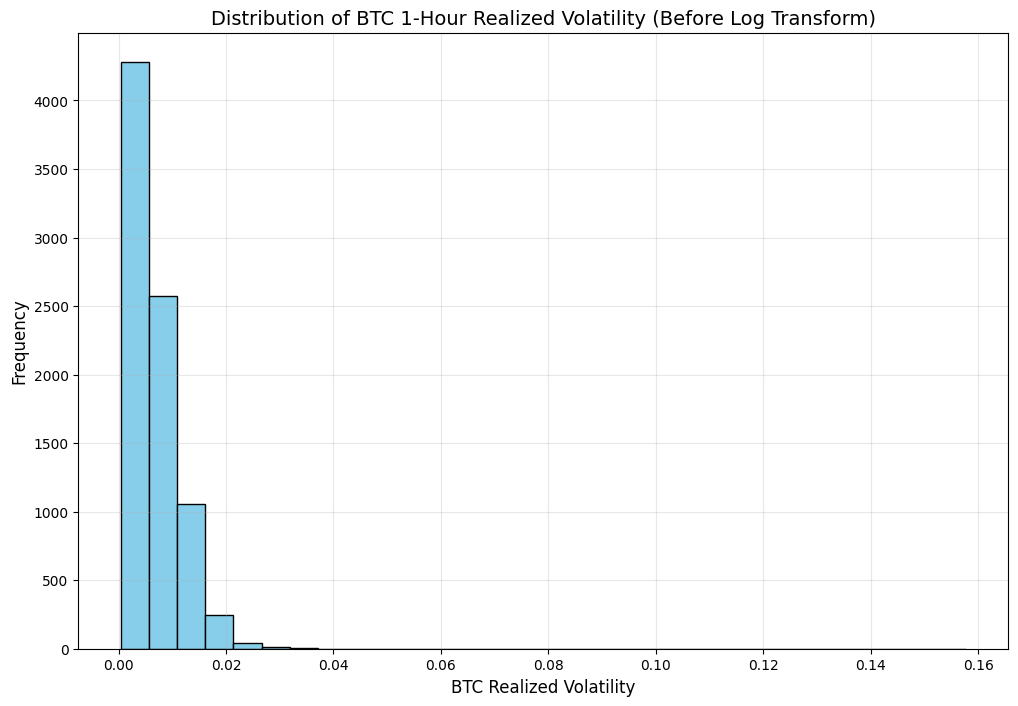

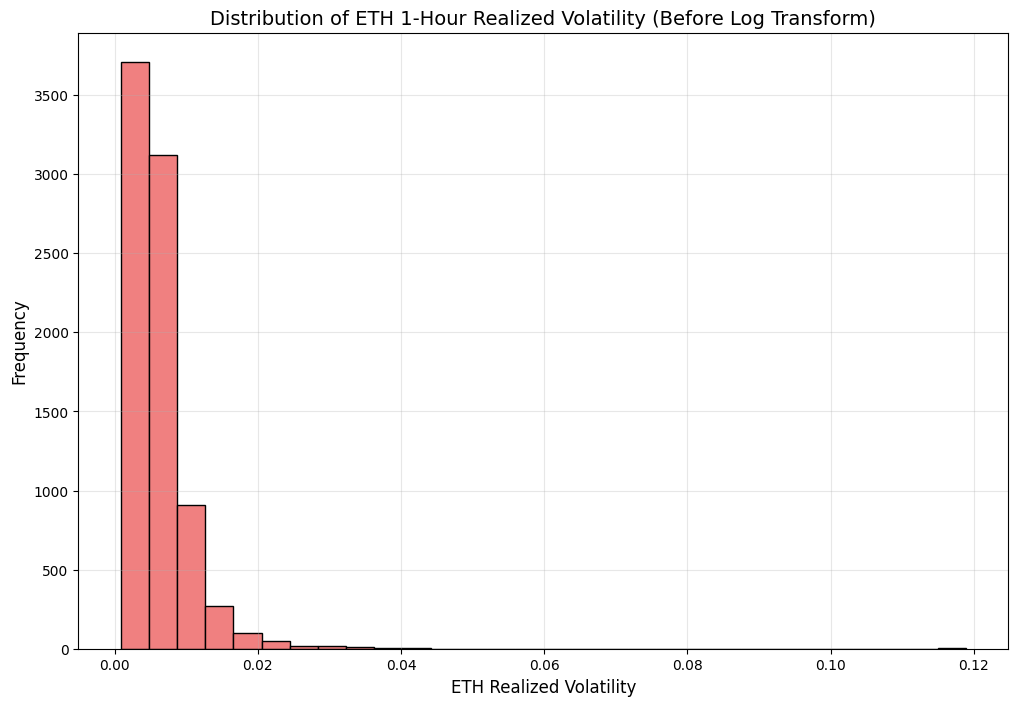

In [650]:

btc_final['vol_future'].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.title("Distribution of BTC 1-Hour Realized Volatility (Before Log Transform)", fontsize=14)
plt.xlabel("BTC Realized Volatility", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

eth_final['vol_future'].hist(bins=30, figsize=(12, 8), color='lightcoral', edgecolor='black')
plt.title("Distribution of ETH 1-Hour Realized Volatility (Before Log Transform)", fontsize=14)
plt.xlabel("ETH Realized Volatility", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [647]:
eth_final['log_vol_future'] = np.log(eth_final['vol_future'])
btc_final['log_vol_future'] = np.log(btc_final['vol_future'])

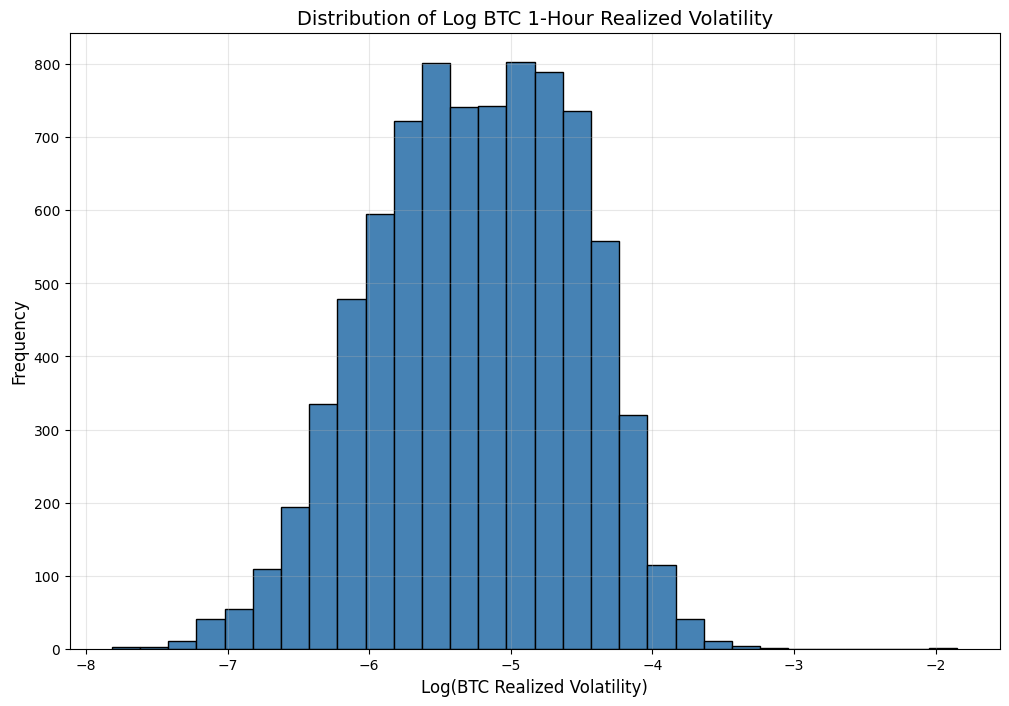

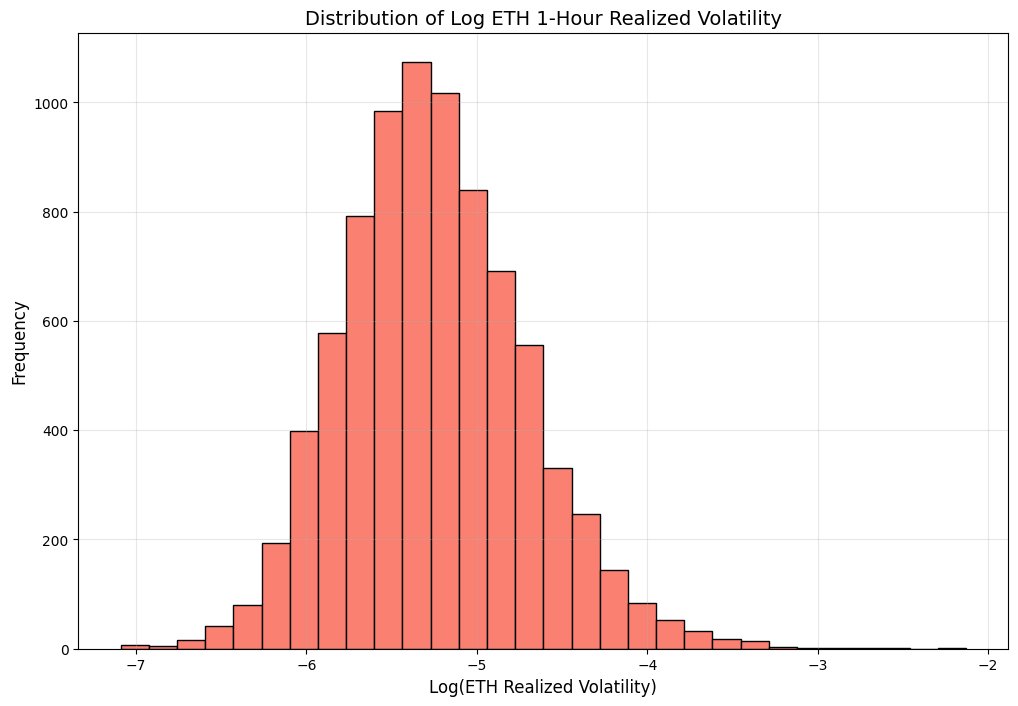

In [651]:
btc_final['log_vol_future'].hist(bins=30, figsize=(12, 8), color='steelblue', edgecolor='black')
plt.title("Distribution of Log BTC 1-Hour Realized Volatility", fontsize=14)
plt.xlabel("Log(BTC Realized Volatility)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

eth_final['log_vol_future'].hist(bins=30, figsize=(12, 8), color='salmon', edgecolor='black')
plt.title("Distribution of Log ETH 1-Hour Realized Volatility", fontsize=14)
plt.xlabel("Log(ETH Realized Volatility)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [649]:
# btc_final.to_csv('../Data/btc_final_df.csv', index=False)
# eth_final.to_csv('../Data/eth_final_df.csv', index=False)